In [1]:
# Análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC

# Entrenamiento y test
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Validaciones y reducción
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

# Pipelines
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Herramientas de preprocesamiento
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

# Cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


## EDAs

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [4]:
# Elimino las columnas id, name, host_id, host_name y last_review. Mantengo el host_id.
df.drop(['id','name', 'host_name', 'last_review'], axis= 1, inplace=True)

In [5]:
# Compruebo duplicados
df.duplicated().sum()

0

In [6]:
# Reviso la información de las columnas numéricas
df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


* Hay viviendas que el precio está a 0, considero que es un valor nulo y lo reemplazo con nan.

In [7]:
df['price']= df['price'].replace((0), np.nan)

In [8]:
# Compruebo nulos
df.isnull().sum()

host_id                               0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                11
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

* Decido rellenar con 0 la columna reviews_per_month porque son anuncios nuevos que tienen el valor 0 en la columna number_of_reviews, al no tener todavía reviews, las columnas reviews_per_month y last_review también estarán a 0.

* Los nulos del precio los relleno con la mediana.

In [9]:
df['reviews_per_month']= SimpleImputer(strategy='constant', fill_value=0).fit_transform(df[['reviews_per_month']])
df['price'] = SimpleImputer(strategy='median').fit_transform(df[['price']])

In [10]:
# Los nulos de la columna 'name' solo son 16 valores, los relleno como 'Unknown' porque es una descripción breve con palabras clave o el título del alquiler personalizado por el anfitrión.
# df['name']= SimpleImputer(strategy='constant', fill_value='Unknown').fit_transform(df[['name']]).ravel()
# Lo dejo comentado porque de momento no voy a utilizar la columna name.

df.isnull().sum()

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [11]:
# EDA de las columnas price y room_type que son los valores que vamos a predecir.

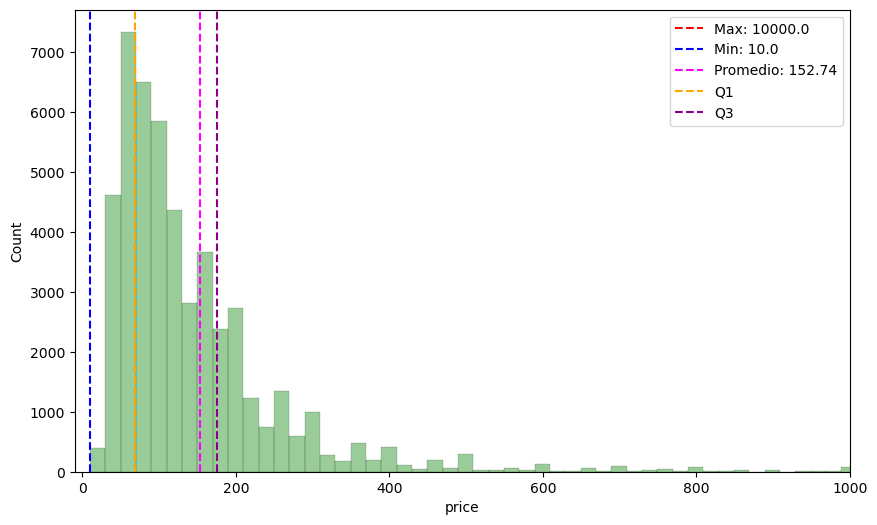

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df, x= 'price', bins=500, alpha= 0.4, color= "green")
plt.axvline(df["price"].max(), color='red', linestyle='dashed', label=f"Max: {df["price"].max()}")
plt.axvline(df["price"].min(), color='blue', linestyle='dashed', label=f"Min: {df["price"].min()}")
plt.axvline(df["price"].mean(), color='magenta',linestyle='dashed', label=f"Promedio: {df["price"].mean():.2f}")
plt.axvline(df["price"].quantile(0.25), color='orange', linestyle='dashed', label= f"Q1")
plt.axvline(df["price"].quantile(0.75), color='darkmagenta', linestyle='dashed', label= f"Q3")
plt.xlim(-10, 1000) # Limito a 1000$ porque con un value_counts he comprobado que por encima de 1000$ solo hay 239 pisos 
plt.legend();

Se visualizan outliers muy claros, ya que hay pisos de precio por noche de 10$ y 10.000$, el mayor número se encuentra por debajo de la media 150$.

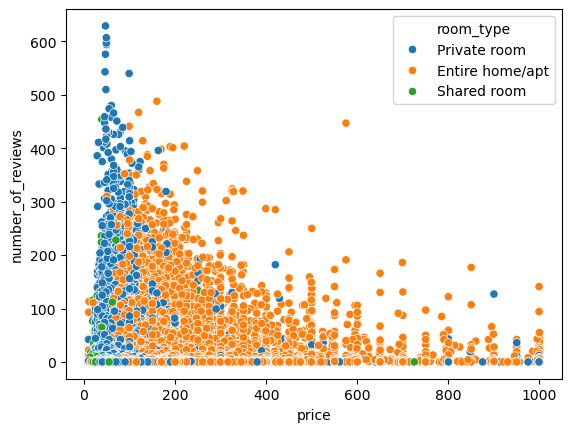

In [13]:
sns.scatterplot(df[df['price'] <= 1000], x= 'price', y='number_of_reviews', hue='room_type');

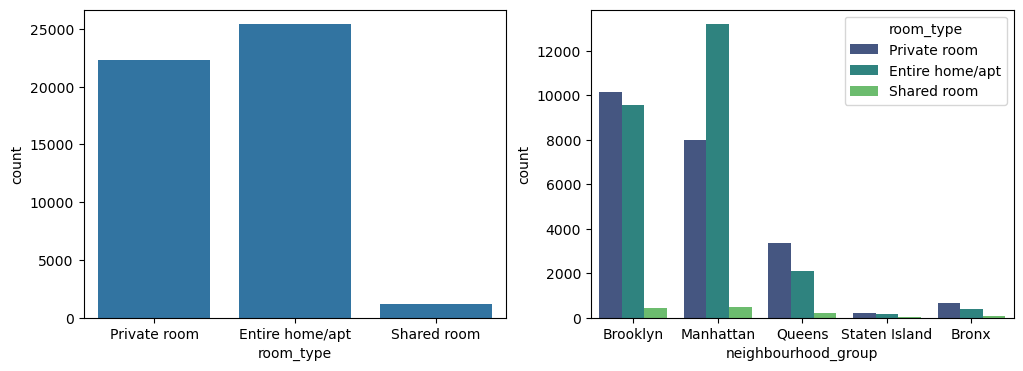

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) 
sns.countplot(df, x='room_type')
plt.subplot(1, 2, 2) 
sns.countplot(df, x='neighbourhood_group', hue='room_type', palette='viridis');

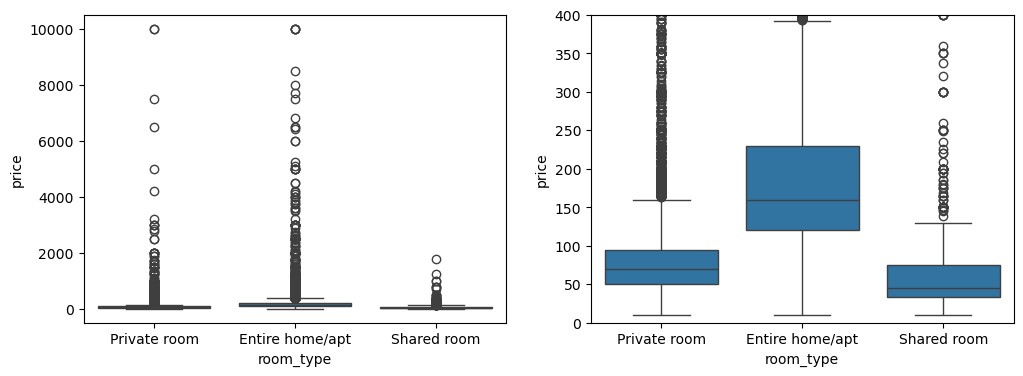

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1) 
sns.boxplot(data=df, y='price', x='room_type')
plt.subplot(1, 2, 2) 
sns.boxplot(data=df, y= 'price', x='room_type')
plt.ylim(0,400); # Limito el precio porque apenas se distingue en el primero

Muy desbalanceado, la clase de habitación compartida tiene un valor muy bajo, se reparten entre habitación privada y casa entera. En la clasificación probaré a aplicar sobremuestreo para equilibrar.

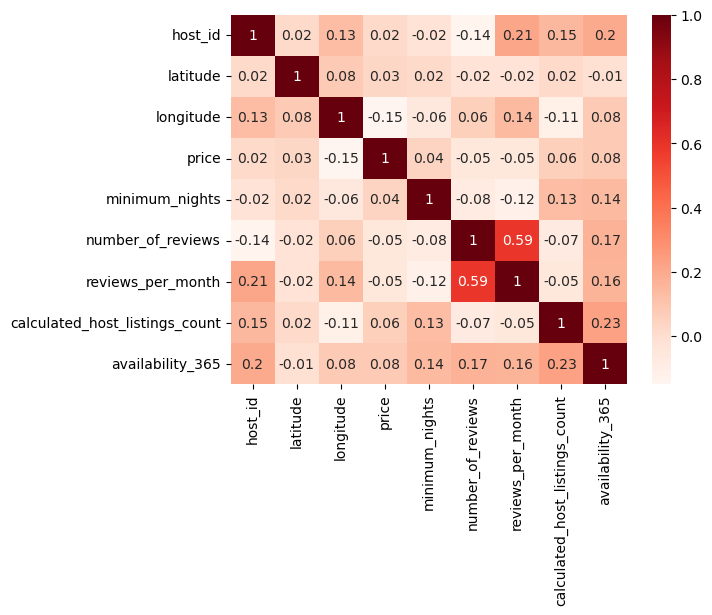

In [16]:
# Correlación de las columnas numéricas
sns.heatmap(df.corr(numeric_only=True).round(2), annot=True, cmap='Reds');

* No hay apenas relación del precio. 

* Voy a quitar outliers para ver si mejora. 
    - He probado los resultados quitando outliers con Tukey y Z-Score, quedándome con Tukey.

* Aplico transformación al precio.

In [17]:
# Outliers
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
lim_lower = Q1 - 1.5 * IQR
lim_upper=  Q3 + 1.5 * IQR
outliers = df[(df["price"] < lim_lower) | (df["price"] > lim_upper)]
df_sin_outliers = df[(df["price"] >= lim_lower) & (df["price"] <= lim_upper)]
print(f"Total df sin outliers: {len(df_sin_outliers)}")
print(f"Total de outliers: {len(outliers)}")

Total df sin outliers: 45923
Total de outliers: 2972


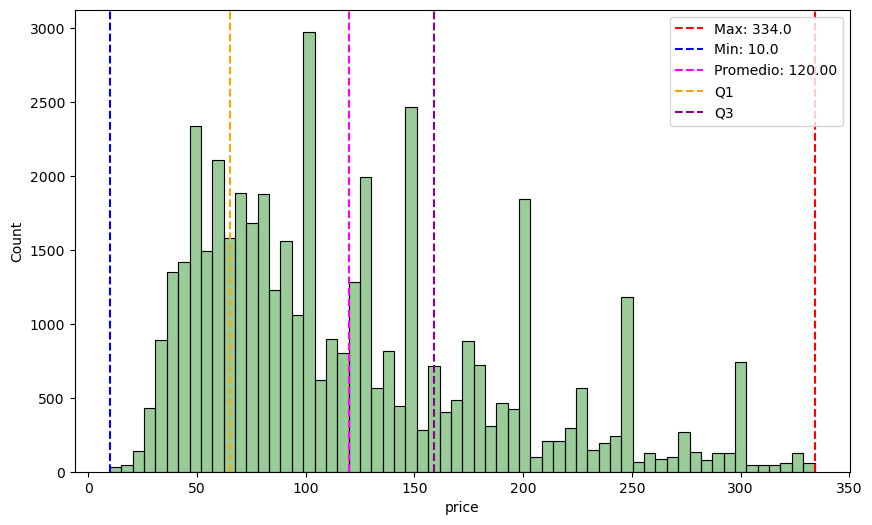

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(df_sin_outliers, x= 'price', alpha= 0.4, color= "green")
plt.axvline(df_sin_outliers["price"].max(), color='red', linestyle='dashed', label=f"Max: {df_sin_outliers["price"].max()}")
plt.axvline(df_sin_outliers["price"].min(), color='blue', linestyle='dashed', label=f"Min: {df_sin_outliers["price"].min()}")
plt.axvline(df_sin_outliers["price"].mean(), color='magenta',linestyle='dashed', label=f"Promedio: {df_sin_outliers["price"].mean():.2f}")
plt.axvline(df_sin_outliers["price"].quantile(0.25), color='orange', linestyle='dashed', label= f"Q1")
plt.axvline(df_sin_outliers["price"].quantile(0.75), color='darkmagenta', linestyle='dashed', label= f"Q3")
plt.legend();

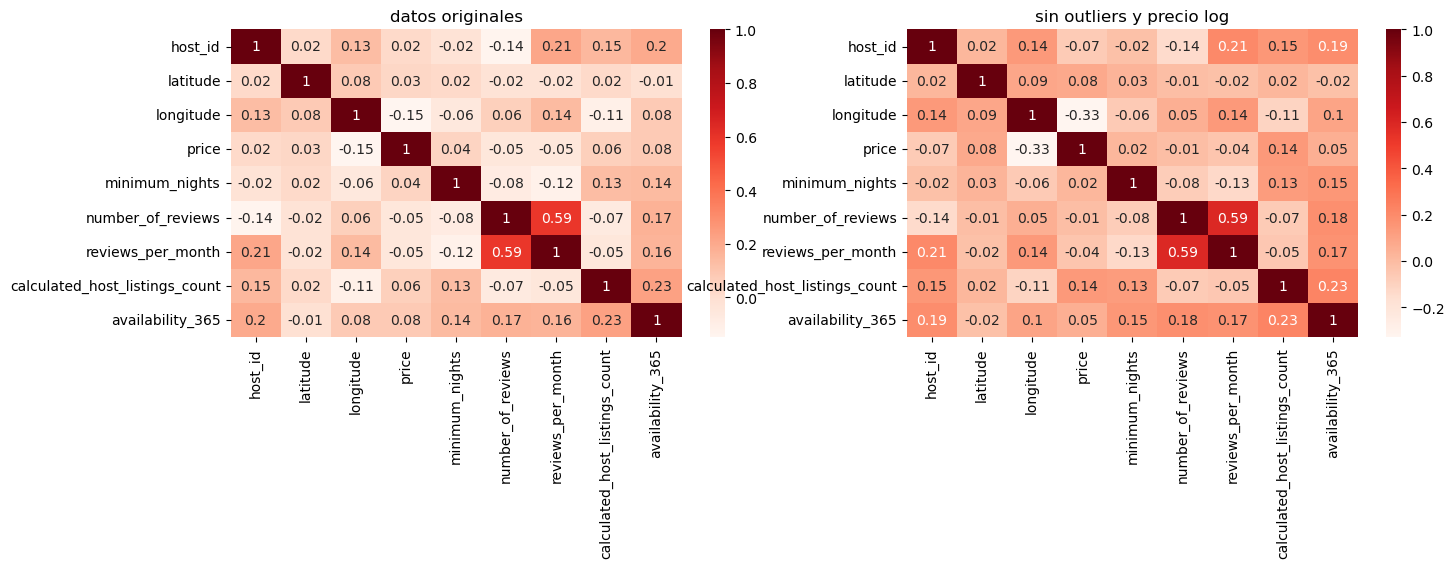

In [19]:
# Comparación de correlación antes y después
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1) 
sns.heatmap(df.corr(numeric_only=True).round(2), annot=True, cmap='Reds');
plt.title("datos originales")

# Aplico transformación logarítmica al precio, entre sqrt y log me da mejor resultado log1p
plt.subplot(1, 2, 2) 
df1 = df_sin_outliers.copy()
df1['price'] = np.log1p(df1['price'])
sns.heatmap(df1.corr(numeric_only=True).round(2), annot=True, cmap='Reds')
plt.title("sin outliers y precio log");

In [20]:
df_dummies= pd.get_dummies(df1, columns=["room_type", 'neighbourhood_group'])
df_dummies.corr(numeric_only=True)[['price']].sort_values('price', ascending=False)

,price
price,1.000000
room_type_Entire home/apt,0.660750
neighbourhood_group_Manhattan,0.342770
calculated_host_listings_count,0.142917
latitude,0.077731
availability_365,0.048070
minimum_nights,0.024493
number_of_reviews,-0.008548
reviews_per_month,-0.041191
neighbourhood_group_Staten Island,-0.047492


Conclusión EDA:
Datos con muchos outliers por precios muy altos y la clase muy desbalanceada. 
Al hacer get_dummies con las 2 principales columnas categóricas ya se aprecia más correlación con el precio que con el resto de numéricas. 
He encontrado la mayor correlación 1º quitando outliers (elimina casi 3000 viviendas de precio superior a 334$)
y después aplicando logaritmo natural al precio, en ese orden.

## PREPROCESADOS
Ya he tratado los nulos en el apartado de EDAs con SimpleImputer, ahora voy a escalar las columnas numéricas y a codificar las categóricas de la entrada X.

# Codificación 
* A la columna neighbourhood_group le voy a aplicar el LabelEncoder ya que son 5 distritos que no mantienen un orden por tamaño o precio. 
* A room_type, en cambio, le voy a aplicar OrdinalEncoder porque considero que es más valioso el alquiler de un apartamento entero, seguido de una habitación privada y lo más barato es la habitación compartida. 
* A neighbour_group voy a probar si le va mejor TargetEncoder.

In [21]:
# df = df original
# df1 = df sin outliers y con precio log
# df2 = df1 codificado
df_resultados = pd.DataFrame(columns=['Datos', 'Encoder', 'R2'])
df2 = df1.copy()
df2['neighbourhood_group']= LabelEncoder().fit_transform(df2['neighbourhood_group'])
encoder = OrdinalEncoder(categories=[['Shared room', 'Private room', 'Entire home/apt']])
df2['room_type'] = encoder.fit_transform(df2[['room_type']])
df2['neighbourhood'] = TargetEncoder().fit_transform(df2[['neighbourhood']], df2['price'])

df2 = df2.astype({"neighbourhood_group": "int64", "room_type": "int64", "neighbourhood": "float64"})

In [22]:
# DF original (con outliers y sin tocar el precio)
X = df.drop('price', axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])
  
model = LinearRegression()
model.fit(X_train, y_train)
    
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
df_resultados.loc[len(df_resultados)] = {'Datos': 'DF original', 'Encoder': 'Ordinal', 'R2': r2}
df_resultados.sort_values('R2', ascending=False)

,Datos,Encoder,R2
0,DF original,Ordinal,0.110079


In [23]:
# DF sin outliers y con precio logarítmico
X = df1.drop('price', axis=1)
y = df1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])
    
model = LinearRegression()
model.fit(X_train, y_train)
    
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
df_resultados.loc[len(df_resultados)] = {'Datos': 'Sin outliers y log', 'Encoder': 'Ordinal', 'R2': r2}
df_resultados.sort_values('R2', ascending=False)

,Datos,Encoder,R2
1,Sin outliers y log,Ordinal,0.504499
0,DF original,Ordinal,0.110079


In [24]:
# DF sin outliers, con sqrt al precio y columnas codificadas.

X = df2.drop('price', axis=1)
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
model = LinearRegression()
model.fit(X_train, y_train)
    
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
df_resultados.loc[len(df_resultados)] = {'Datos': 'Codificado', 'Encoder': 'TargetEncoder', 'R2': r2}
df_resultados.sort_values('R2', ascending=False)

,Datos,Encoder,R2
2,Codificado,TargetEncoder,0.572431
1,Sin outliers y log,Ordinal,0.504499
0,DF original,Ordinal,0.110079


* Con LinearRegression para reducir tiempo en esta fase y OrdinalEncoder, el df sin outliers y aplicando al target el log aumenta de 0.11 a 0.50.

# REGRESIÓN
Empiezo con el df sin outliers, con precio log y sin nulos, para no repetir código.
No necesita SimpleImputer.

# Pipelines 
Para probar varios preprocesados y encontrar la mejor combinación.

In [25]:
encoders = {
    'OneHot': OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    'Target': TargetEncoder()   
}

scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler()
}

transformers = {
    'Power': PowerTransformer(),
    'QuantileTransformer': QuantileTransformer()}

models = {
    'LR' : LinearRegression(),
    'GBR': GradientBoostingRegressor(),
    'RF': RandomForestRegressor()
    }

In [26]:
X = df1.drop('price', axis=1)
y = df1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = X_train.select_dtypes(include=[np.number]).columns
print('numerical_cols', numerical_cols)

categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns
print('categorical_cols', categorical_cols)

df_testing = pd.DataFrame(columns=['Encoder', 'Scaler', 'Transformer', 'Model', 'R2', 'MAE', 'RMSE', 'MAPE'])

numerical_cols Index(['host_id', 'latitude', 'longitude', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')
categorical_cols Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')


In [27]:
# tarda 15 minutos
for encoder_name, encoder in encoders.items():
    for scaler_name, scaler in scalers.items():
        for transformer_name, transformer in transformers.items():
            for model_name, model in models.items():
                print(f'Combination: coder= {encoder_name}, scaler={scaler_name}, transformer={transformer_name} Model={model_name}')   
                
                pipeline_categorical = Pipeline([
                        ('encoder', encoder)])
                        
                pipeline_num = Pipeline([
                        ('scaler', scaler),
                        ('transformer', transformer)])
                
                pipeline_all= ColumnTransformer([
                    ('categ', pipeline_categorical, categorical_cols),
                    ('num', pipeline_num, numerical_cols)])

                pipeline = Pipeline([
                    ('pipeline', pipeline_all),
                    ('model', model)])

                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)
                r2 = r2_score(y_test, y_pred)
                mae = mean_absolute_error(y_test, y_pred)
                rmse = root_mean_squared_error(y_test, y_pred)
                mape = mean_absolute_percentage_error(y_test, y_pred)

                df_testing.loc[len(df_testing)] = {
                    'Encoder': encoder_name,
                    'Scaler': scaler_name,
                    'Transformer': transformer_name,
                    'Model': model_name,
                    'R2': r2,
                    'MAE': mae,
                    'RMSE': rmse,
                    'MAPE': mape}
df_testing.sort_values('R2', ascending=False).head(5)

Combination: coder= OneHot, scaler=Standard, transformer=Power Model=LR
Combination: coder= OneHot, scaler=Standard, transformer=Power Model=GBR
Combination: coder= OneHot, scaler=Standard, transformer=Power Model=RF
Combination: coder= OneHot, scaler=Standard, transformer=QuantileTransformer Model=LR
Combination: coder= OneHot, scaler=Standard, transformer=QuantileTransformer Model=GBR
Combination: coder= OneHot, scaler=Standard, transformer=QuantileTransformer Model=RF
Combination: coder= OneHot, scaler=MinMax, transformer=Power Model=LR
Combination: coder= OneHot, scaler=MinMax, transformer=Power Model=GBR
Combination: coder= OneHot, scaler=MinMax, transformer=Power Model=RF
Combination: coder= OneHot, scaler=MinMax, transformer=QuantileTransformer Model=LR
Combination: coder= OneHot, scaler=MinMax, transformer=QuantileTransformer Model=GBR
Combination: coder= OneHot, scaler=MinMax, transformer=QuantileTransformer Model=RF
Combination: coder= OneHot, scaler=Robust, transformer=Power

,Encoder,Scaler,Transformer,Model,R2,MAE,RMSE,MAPE
17,OneHot,Robust,QuantileTransformer,RF,0.641694,0.258218,0.340154,0.056576
2,OneHot,Standard,Power,RF,0.641526,0.257995,0.340233,0.056535
20,Target,Standard,Power,RF,0.641512,0.258946,0.340240,0.056783
32,Target,Robust,Power,RF,0.641336,0.258473,0.340324,0.056668
11,OneHot,MinMax,QuantileTransformer,RF,0.641036,0.258427,0.340466,0.056619


In [28]:
'''	Encoder	Scaler	Transformer	       Model	R2	    MAE	        RMSE	    MAPE
11	OneHot	MinMax	QuantileTransformer	RF	0.642270	0.257840	0.339880	0.056499
14	OneHot	Robust	Power	            RF	0.641839	0.258132	0.340085	0.056569
17	OneHot	Robust	QuantileTransformer	RF	0.641135	0.258063	0.340419	0.056533
23	Target	StandardQuantileTransformer	RF	0.640832	0.258462	0.340563	0.056655
29	Target	MinMax	QuantileTransformer	RF	0.640788	0.258694	0.340583	0.056710'''

'\tEncoder\tScaler\tTransformer\t       Model\tR2\t    MAE\t        RMSE\t    MAPE\n11\tOneHot\tMinMax\tQuantileTransformer\tRF\t0.642270\t0.257840\t0.339880\t0.056499\n14\tOneHot\tRobust\tPower\t            RF\t0.641839\t0.258132\t0.340085\t0.056569\n17\tOneHot\tRobust\tQuantileTransformer\tRF\t0.641135\t0.258063\t0.340419\t0.056533\n23\tTarget\tStandardQuantileTransformer\tRF\t0.640832\t0.258462\t0.340563\t0.056655\n29\tTarget\tMinMax\tQuantileTransformer\tRF\t0.640788\t0.258694\t0.340583\t0.056710'

* Probando los encoders OneHotEncoder y TargetEncoder, el mejor resultado lo obtengo con la combinación:
    * OneHotEncoder + MinMaxScaler + QuantileTransformer en RandomForestRegressor

In [29]:
# Modelo elegido para regresión

X = df1.drop(['price'], axis=1)
y = df1['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_cols = X_train.select_dtypes(include=[np.number]).columns
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns

pipeline_categorical = Pipeline([
        ('encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

pipeline_num = Pipeline([
        ('scaler', MinMaxScaler()),
        ('transformer', QuantileTransformer())])

pipeline_all= ColumnTransformer([
    ('categ', pipeline_categorical, categorical_cols),
    ('num', pipeline_num, numerical_cols)])

pipeline = Pipeline([
    ('pipeline', pipeline_all),
    ('model', RandomForestRegressor())])

pipeline.fit(X_train, y_train)

X_train_transformed = pipeline_all.fit_transform(X_train)
X_test_transformed = pipeline_all.transform(X_test)

# GridsearchCV

In [30]:
# Tarda 10 minutos
modelo = RandomForestRegressor(random_state=42)
parametros = {
    'n_estimators': [100,200],
    'max_depth': [None, 10, 20]
}
grid = GridSearchCV(modelo, parametros, scoring=['r2', 
                                                 'neg_mean_absolute_error',
                                                 'neg_mean_squared_error',
                                                 'neg_mean_absolute_percentage_error',
                                                 'neg_root_mean_squared_error'
                                                 ],
                    refit='r2', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_transformed, y_train)

print("Mejores Parámetros:", grid.best_params_)
print("Mejor puntuación:", grid.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores Parámetros: {'max_depth': 20, 'n_estimators': 200}
Mejor puntuación: 0.6496912988719904


In [31]:
# Fitting 5 folds for each of 6 candidates, totalling 30 fits
# Mejores Parámetros: {'max_depth': 20, 'n_estimators': 200}
# Mejor puntuación: 0.6498229307214134

# Feature selection
    * SelectKBest con f_regression

In [32]:
df_select = pd.DataFrame(columns=['Modelo', 'R2'])

for k in range(1, X_train_transformed.shape[1] + 1):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_transformed, y_train)
    X_test_selected = selector.transform(X_test_transformed)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)
    
    df_select.loc[len(df_select)] = [f'Columnas seleccionadas {k}', r2]
    
df_select.sort_values('R2', ascending=False).head(5)

,Modelo,R2
221,Columnas seleccionadas 222,0.595527
216,Columnas seleccionadas 217,0.595521
220,Columnas seleccionadas 221,0.595520
222,Columnas seleccionadas 223,0.595518
218,Columnas seleccionadas 219,0.595506


In [33]:
pipeline = Pipeline([
    ('pipeline', pipeline_all),
    ('selector', SelectKBest(score_func=f_regression, k=222)),
    ('model', RandomForestRegressor(n_estimators=200, 
                                     max_depth=20,
                                     random_state=42))])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)
print("R2 en test:", r2)

X_train_transformed = pipeline_all.fit_transform(X_train)
X_test_transformed = pipeline_all.transform(X_test)

R2 en test: 0.6439878121348883


# Cross_validate

In [34]:
# Tarda 7 minutos
models = {
    'LinearRegression': LinearRegression(),
    'GBR': GradientBoostingRegressor(),
    'RandomForest': RandomForestRegressor()}

df_list = []
for name, model in models.items(): 
    
    results = cross_validate(model, X_train_transformed, y_train, 
               scoring='r2')
    df_model = pd.DataFrame(results)
    df_model['modelo'] = name
    df_list.append(df_model)

df_cross_r = pd.concat(df_list, ignore_index=True)
df_cross_r.sort_values('test_score', ascending=False).head(5)

,fit_time,score_time,test_score,modelo
13,47.359158,0.368155,0.657168,RandomForest
11,47.905877,0.363851,0.655375,RandomForest
14,47.621305,0.381641,0.653352,RandomForest
6,27.082403,0.027108,0.644074,GBR
8,28.692108,0.014714,0.643362,GBR


In [35]:
'''    fit_time	score_time	test_score	modelo
13	47.882803	0.352738	0.657609	RandomForest
11	47.335209	0.371950	0.656425	RandomForest
14	47.355764	0.367087	0.653301	RandomForest
6	26.994191	0.018083	0.644098	GBR
8	28.300225	0.025917	0.643368	GBR'''

'    fit_time\tscore_time\ttest_score\tmodelo\n13\t47.882803\t0.352738\t0.657609\tRandomForest\n11\t47.335209\t0.371950\t0.656425\tRandomForest\n14\t47.355764\t0.367087\t0.653301\tRandomForest\n6\t26.994191\t0.018083\t0.644098\tGBR\n8\t28.300225\t0.025917\t0.643368\tGBR'

In [36]:
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, subplot_titles=('Tiempo de entrenamiento', 'R2 Score'))
fig.add_trace(px.box(df_cross_r, x='modelo', y='fit_time', color_discrete_sequence=px.colors.sequential.Plasma).data[0], row=1, col=1)
fig.add_trace(px.box(df_cross_r, x='modelo', y='test_score', color_discrete_sequence=px.colors.sequential.Plasma).data[0], row=1, col=2)

In [37]:
y_test_sq = np.expm1(y_test)
y_pred_sq = np.expm1(y_pred)
df_test = pd.DataFrame({'Real': y_test_sq, 'Estimado': y_pred_sq})
df_test['Diferencia'] = df_test['Real'] - df_test['Estimado']
df_test.head(10)

,Real,Estimado,Diferencia
40961,42.0,52.079916,-10.079916
530,75.0,61.625867,13.374133
22963,168.0,163.402404,4.597596
48421,125.0,122.626150,2.373850
11792,300.0,144.695352,155.304648
3480,150.0,155.343146,-5.343146
5247,39.0,45.360629,-6.360629
45284,40.0,63.471580,-23.471580
38387,49.0,88.727524,-39.727524
12370,83.0,167.886803,-84.886803


# Clustering

In [38]:
kmeans = KMeans(n_clusters=5, random_state=42)
X_train["cluster"] = kmeans.fit_predict(X_train_transformed)
X_train["cluster"].value_counts()

cluster
1    9207
0    8561
4    7292
2    6509
3    5169
Name: count, dtype: int64

In [39]:
print('kmeans.labels_', kmeans.labels_[:10])
print('kmeans.inertia_', kmeans.inertia_)
print('silhouette_score', silhouette_score(X_train_transformed, kmeans.labels_))

kmeans.labels_ [3 0 2 2 3 2 1 4 4 1]
kmeans.inertia_ 66657.2216464658
silhouette_score 0.19689501191677827


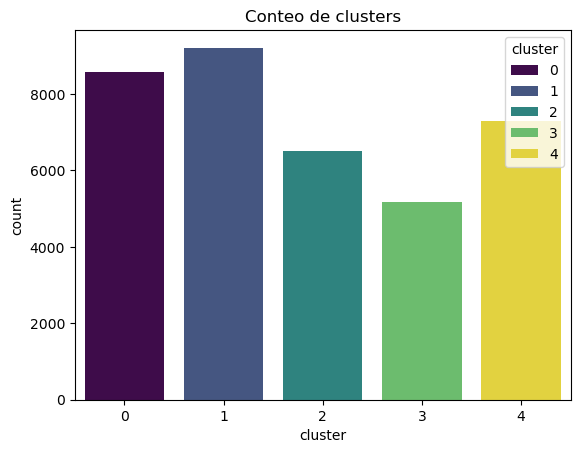

In [40]:
sns.countplot(X_train, x='cluster', palette='viridis', hue='cluster')
plt.title('Conteo de clusters');

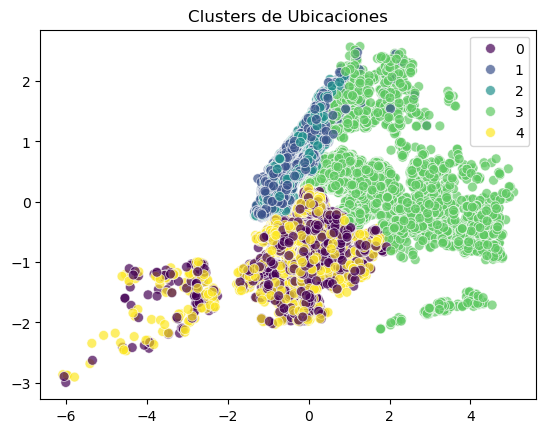

In [41]:
scaler = RobustScaler()
long = scaler.fit_transform(X_train[['longitude']]).flatten()
lat = scaler.fit_transform(X_train[['latitude']]).flatten()
sns.scatterplot(x=long, y=lat, hue=X_train['cluster'], palette='viridis', s=50, alpha=0.7)
plt.legend()
plt.title('Clusters de Ubicaciones')
plt.show()

# CLASIFICACIÓN

In [42]:
df = pd.read_csv('AB_NYC_2019.csv')
df.drop(['id','name', 'host_name', 'last_review'], axis= 1, inplace=True)
df['reviews_per_month']= SimpleImputer(strategy='constant', fill_value=0).fit_transform(df[['reviews_per_month']])

In [43]:
# sns.pairplot(df, hue='room_type')
# Dejo comentado el pairplot porque tarda 5 minutos en ejecutarse.
# Bastante superposición de puntos que puede causar que la clasificación no sea tan precisa.
# Veo mejor diferencia en las variables precio y número de reseñas, apenas hay puntos de habitación compartida en general.

Aplico la codificación ya a las columnas categóricas para tener el dataframe solo con numéricas y que sea más ligero en los bucles al no aplicar pipeline categórico.

In [44]:
# Shared room: 0 | Private room: 1 | Entire home/apt: 2 
encoder = OrdinalEncoder(categories=[['Shared room', 'Private room', 'Entire home/apt']])
df['room_type'] = encoder.fit_transform(df[['room_type']])
df['neighbourhood'] = LabelEncoder().fit_transform(df['neighbourhood'])
df['neighbourhood_group'] = LabelEncoder().fit_transform(df['neighbourhood_group'])

In [45]:
df_resultados = pd.DataFrame(columns=['Modelo', 'accuracy', 'precision', 'recall', 'f1', 'AUC'])

def calculate_metrics(scaler_name, transformer_name, model_name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    df_resultados.loc[len(df_resultados)] = [f' {scaler_name} {transformer_name} {model_name}', accuracy, precision, recall, f1, auc]

In [46]:
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler()
    }

transformers = {
    'Power': PowerTransformer(),
    'Quantile': QuantileTransformer()
    }
models = {
    'LR' : LogisticRegression(max_iter=2000),
    'KNN': KNeighborsClassifier(), # CODO KNN
    'Tree': DecisionTreeClassifier(),
    'RF': RandomForestClassifier()
    }

In [47]:
X = df.drop('room_type', axis=1)
y = df['room_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

for scaler_name, scaler in scalers.items():
    for transformer_name, transformer in transformers.items():
        for model_name, model in models.items():
            print(f'Combination: scaler={scaler_name}, transformer={transformer_name} Model={model_name}')               
                  
            pipeline_num = Pipeline([
                    ('scaler', scaler),
                    ('transformer', transformer)])
            
            pipeline = make_pipeline(
                pipeline_num,
                model)

            calculate_metrics(scaler_name, transformer_name, model_name, pipeline)
df_resultados.sort_values('AUC', ascending=False).head(5)

Combination: scaler=Standard, transformer=Power Model=LR
Combination: scaler=Standard, transformer=Power Model=KNN
Combination: scaler=Standard, transformer=Power Model=Tree
Combination: scaler=Standard, transformer=Power Model=RF
Combination: scaler=Standard, transformer=Quantile Model=LR
Combination: scaler=Standard, transformer=Quantile Model=KNN
Combination: scaler=Standard, transformer=Quantile Model=Tree
Combination: scaler=Standard, transformer=Quantile Model=RF
Combination: scaler=MinMax, transformer=Power Model=LR
Combination: scaler=MinMax, transformer=Power Model=KNN
Combination: scaler=MinMax, transformer=Power Model=Tree
Combination: scaler=MinMax, transformer=Power Model=RF
Combination: scaler=MinMax, transformer=Quantile Model=LR
Combination: scaler=MinMax, transformer=Quantile Model=KNN
Combination: scaler=MinMax, transformer=Quantile Model=Tree
Combination: scaler=MinMax, transformer=Quantile Model=RF
Combination: scaler=Robust, transformer=Power Model=LR
Combination: 

,Modelo,accuracy,precision,recall,f1,AUC
23,Robust Quantile RF,0.860517,0.883412,0.698755,0.747641,0.913830
3,Standard Power RF,0.861233,0.877990,0.703437,0.751632,0.912203
11,MinMax Power RF,0.859802,0.885947,0.695599,0.744631,0.910684
15,MinMax Quantile RF,0.862256,0.882254,0.705437,0.754292,0.909012
19,Robust Power RF,0.859597,0.880146,0.702288,0.751013,0.908285


In [ ]:
'''  	     Modelo	        accuracy	precision	recall	    f1	        AUC
23	Robust Quantile RF	    0.860517	0.883412	0.698755	0.747641	0.913830
3	Standard Power RF	    0.861233	0.877990	0.703437	0.751632	0.912203
11	MinMax Power RF	        0.859802	0.885947	0.695599	0.744631	0.910684
15	MinMax Quantile RF	    0.862256	0.882254	0.705437	0.754292	0.909012
19	Robust Power RF	        0.859597	0.880146	0.702288	0.751013	0.908285
'''

'  \t     Modelo\t        accuracy\tprecision\trecall\t    f1\t        AUC\n3\tStandard Power RF\t    0.861029\t0.888025\t0.704659\t0.754505\t0.914974\n19\tRobust Power RF\t        0.859597\t0.883004\t0.699563\t0.748552\t0.911492\n7\tStandard Quantile RF\t0.860722\t0.880388\t0.700285\t0.748789\t0.910889\n11\tMinMax Power RF\t        0.859495\t0.879794\t0.700869\t0.749466\t0.909567\n15\tMinMax Quantile RF\t    0.859188\t0.876265\t0.700754\t0.748792\t0.909463\n'

In [ ]:
# Modelo elegido para clasificación
X = df.drop('room_type', axis=1)
y = df['room_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline_num = Pipeline([
  ('scaler', RobustScaler()),
  ('transformer', QuantileTransformer())
  ])

pipeline = make_pipeline(
  pipeline_num,
  RandomForestClassifier(n_estimators=200, min_samples_split=20))

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print("AUC en test:", auc)

X_train_transformed = pipeline_num.fit_transform(X_train)
X_test_transformed = pipeline_num.transform(X_test)

AUC en test: 0.9177286031013664


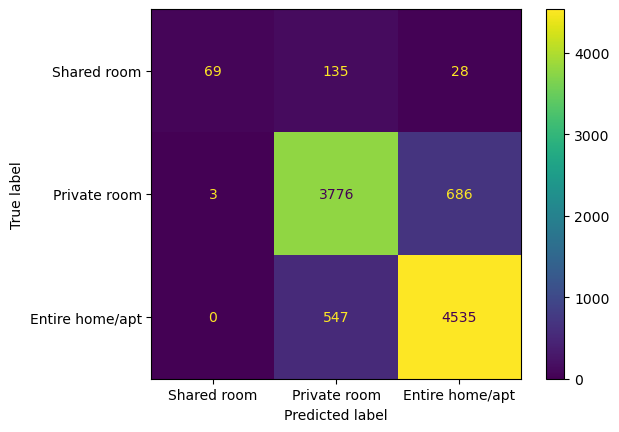

In [50]:
# Matriz de confusión
cm= confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Shared room', 'Private room', 'Entire home/apt'])
cmd.plot();

# PCA

In [51]:
pipeline_num_pca = Pipeline([
    ('scaler', MinMaxScaler()),
    ('transformer', PowerTransformer()),
    ('pca', PCA(n_components=0.95, random_state=42)) 
])

pipeline_pca = make_pipeline(
    pipeline_num_pca,
    RandomForestClassifier(n_estimators=200, min_samples_split=20)
)

pipeline_pca.fit(X_train, y_train)
y_pred_pca = pipeline_pca.predict(X_test)
y_pred_proba_pca = pipeline_pca.predict_proba(X_test)
auc_pca = roc_auc_score(y_test, y_pred_proba_pca, multi_class='ovr')
print("AUC en test con PCA:", auc_pca)
if auc_pca > auc:
    print("El modelo con PCA mejora.")
else:
    print("Incluyendo PCA no mejora.")

AUC en test con PCA: 0.9072236983713459
Incluyendo PCA no mejora.


# SMOTE

In [52]:
from imblearn.pipeline import Pipeline # Lo importo aquí porque pipeline de imblearn afecta al de sklearn 
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_transformed, y_train)
print(y_train.value_counts())
print(y_resampled.value_counts())

room_type
2.0    20327
1.0    17861
0.0      928
Name: count, dtype: int64
room_type
2.0    20327
1.0    20327
0.0    20327
Name: count, dtype: int64


In [53]:
pipeline_smote = Pipeline([
    ('scaler', MinMaxScaler()),
    ('transformer', PowerTransformer()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, min_samples_split=20))
])

pipeline_smote.fit(X_train, y_train)
y_pred_smote = pipeline_smote.predict(X_test)
y_pred_proba_smote = pipeline_smote.predict_proba(X_test)
auc_smote = roc_auc_score(y_test, y_pred_proba_smote, multi_class='ovr')
print("AUC en test con SMOTE:", auc_smote)
if auc_smote > auc:
    print("El modelo con SMOTE mejora.")
else:
    print("Incluyendo SMOTE no mejora.")

AUC en test con SMOTE: 0.9146515337947912
Incluyendo SMOTE no mejora.


# Cross validate clasificación

In [54]:
models = {
    'LR' : LogisticRegression(max_iter=2000),
    'RandomForest': RandomForestClassifier(n_estimators=200, min_samples_split=20),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(n_neighbors=9),
    # 'SVC': SVC(kernel='linear', probability=True) Lo quito porque no mejora a RF y tarda mucho
    }
df_list = []
for name, model in models.items():
    results = cross_validate(model, X_train_transformed, y_train, 
                             scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc_ovr'], 
                             cv=5)
    df_model = pd.DataFrame(results)
    df_model['modelo'] = name
    df_list.append(df_model)

df_cross = pd.concat(df_list, ignore_index=True)


C:\Users\noeli\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\noeli\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\noeli\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\noeli\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no pred

In [55]:
df_cross.sort_values('test_roc_auc_ovr', ascending=False).head(3)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_macro,test_roc_auc_ovr,modelo
6,14.450916,0.550355,0.858878,0.904752,0.671184,0.718031,0.935677,RandomForest
11,22.960074,0.101922,0.854787,0.861606,0.680112,0.725230,0.930017,GradientBoosting
9,14.519659,0.552478,0.861306,0.865403,0.658593,0.698068,0.923523,RandomForest


<Axes: ylabel='modelo'>

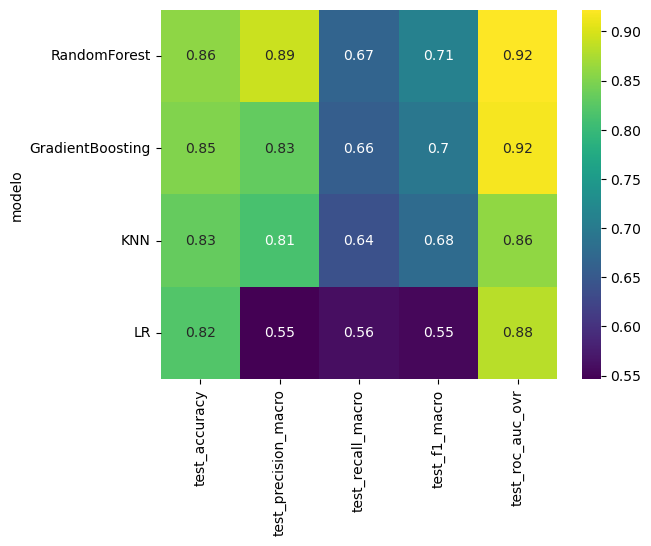

In [56]:
df_pivot = df_cross.groupby('modelo').mean().sort_values('test_f1_macro', ascending=False)
sns.heatmap(df_pivot.drop(columns=['fit_time','score_time']), annot=True, cmap='viridis')

In [96]:
fig = px.box(df_cross, x='modelo', y='fit_time', 
             title='Tiempo de entrenamiento por modelo', 
             labels={'fit_time': 'segundos', 'modelo': 'Modelo'})
fig.update_layout(width=600, height=600)
fig.show()

Conclusiones
* Con la regresión no consigo buen resultado, no hay columnas correlacionadas; mejoraría añadir más columnas con otro tipo de datos que influyan más en el precio. El modelo elegido tiene más de un 25% de error, no es suficiente preciso.

    - Añadiendo una nueva columna "min_cost" = (precio * noches_minimas), que es importante en la selección de un alojamiento por la temporalidad que buscas y además influye directamente en el precio mínimo por día (que es lo que estoy prediciendo) que establece el anfitrión, obtengo un r2 en test de 0.9997. 
    Lo he descartado porque es un derivado directo de la variable objetivo, facilitado a través de las variables de entrada, considero que anula la predicción original y la validez del modelo. 

* En cambio, la clasificación sobre el tipo de habitación tiene buena precisión y el modelo elegido obtiene un AUC de 0.92, distingue bien entre los tipos de alojamiento.